![](https://i0.wp.com/sahilbagwe.com/wp-content/uploads/2020/12/credit-cards-4-steps-1920x1152-2.jpg?resize=750%2C450&ssl=1)

In this notebook, we are going to be training a NN (ANN to be precise) and make predictions on this dataset which contains some independent variable and expects us to classify whether the customer will be churned or not given these features.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib import pyplot
import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('/kaggle/input/credit-card-customer-churn-prediction/Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Dropping the columns that may not be so helpful while making the predictions

In [3]:
df.drop(['RowNumber', 'CustomerId','Surname' ], axis=1, inplace=True)

## Exploratory Data Analysis

Exploratory Data Analysis refers to the critical process of performing initial investigations on data so as to discover patterns,to spot anomalies,to test hypothesis and to check assumptions with the help of summary statistics and graphical representations.

In [4]:
fig = px.histogram(df, 
                   x='Exited', 
                   color='Exited',
                   template='simple_white', 
                   title='Total Customer Churn')
fig.show()

Here we have created a `dataframe` that will have only the data of the customers that are churned.

In [5]:
exiteddf = df[df.Exited.eq(1)]

In [6]:
exiteddf.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
5,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
7,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
16,653,Germany,Male,58,1,132602.88,1,1,0,5097.67,1


In [7]:
fig = px.histogram(exiteddf, 
             x="Geography",
            color='Geography',
             template='simple_white', 
             title = 'Geography Wise customer churn')
fig.show()

In [8]:
fig = px.histogram(exiteddf, 
             x="CreditScore", 
             template='simple_white',
            nbins = 20,
             title = 'CreditScore Wise customer churn',
             barmode='group')
fig.show()

In [9]:
fig = px.histogram(exiteddf, 
                   x='NumOfProducts', 
                   color='NumOfProducts',
                   template='simple_white', 
                   title='Churn by Number Of Products used by customer')
fig.show()

In [10]:
fig = px.histogram(exiteddf, 
                   x='Balance',
                   template='simple_white', 
                   nbins = 20,
                   title='Balance of Churned Customers')
fig.show()

In [11]:
fig = px.histogram(exiteddf, 
                   x='HasCrCard',
                   color='HasCrCard',
                   template='simple_white', 
                   title='Churned Customers owning Credit Card')
fig.show()

In [12]:
fig = px.histogram(exiteddf, 
             x="EstimatedSalary",
            nbins=10,
             template='simple_white', 
             title = 'Estimated Salary Wise customer churn')
fig.show()

In [13]:
fig = px.histogram(exiteddf, 
             x="Tenure",
            nbins=6,
             template='simple_white', 
             title = 'Tenure Wise customer churn')
fig.show()

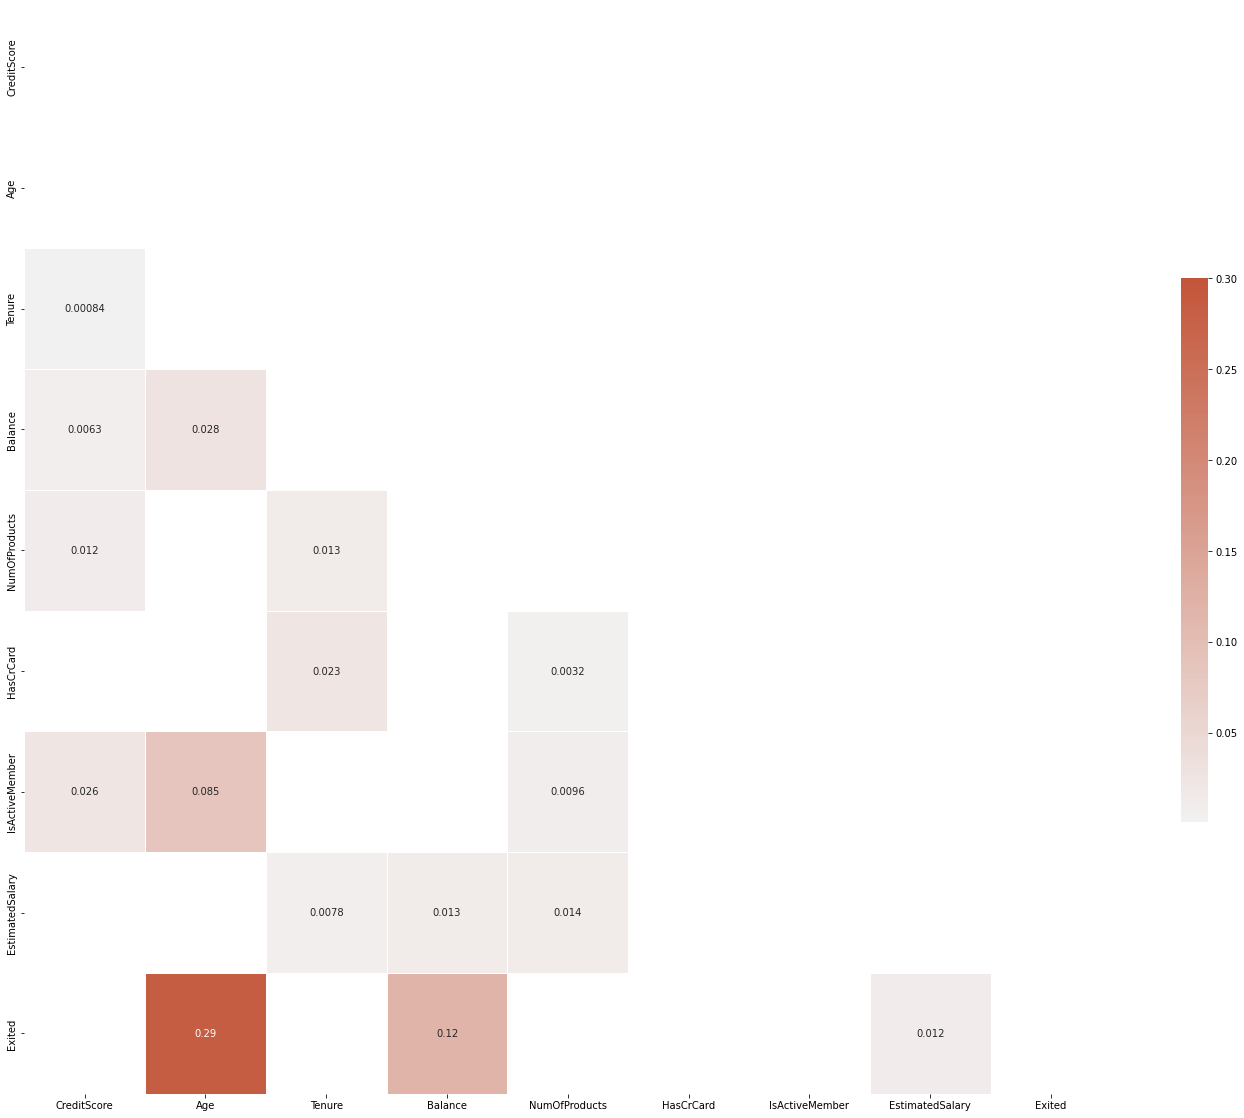

In [14]:
corr = df.corr()
corr = corr[corr > 0.0]
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(25,20))
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True,square=True, linewidths=.5, cbar_kws={'shrink': .5})
plt.show()

## Data Preprocessing

### OneHotEncoding

For categorical variables where no such ordinal relationship exists, the integer encoding is not enough. In fact, using this encoding and allowing the model to assume a natural ordering between categories may result in poor performance or unexpected results (predictions halfway between categories).

In this case, a one-hot encoding can be applied to the integer representation. This is where the integer encoded variable is removed and a new binary variable is added for each unique integer value.

![](https://i.imgur.com/n8GuiOO.png)

Read More on Encoding data https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/

In [15]:
df = pd.get_dummies(df,columns=['Geography','Gender'],drop_first=True)
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


### Declaring X, y values and Splitting Data

In [16]:
X = df.drop(columns=['Exited'])
y = df['Exited'].values
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [17]:
X_train.shape, y_train.shape

((8000, 11), (8000,))

### Scaling

Feature scaling in machine learning is one of the most critical steps during the pre-processing of data before creating a machine learning model. Scaling can make a difference between a weak machine learning model and a better one.

**WHY DO WE NEED SCALING**
1. Machine learning algorithm just sees number — if there is a vast difference in the range say few ranging in thousands and few ranging in the tens, and it makes the underlying assumption that higher ranging numbers have superiority of some sort. So these more significant number starts playing a more decisive role while training the model.
2. Another reason why feature scaling is applied is that few algorithms like Neural network gradient descent **converge much faster** with feature scaling than without it.


![](https://miro.medium.com/max/900/1*yi0VULDJmBfb1NaEikEciA.png)

In [18]:
scaler = StandardScaler()
scaled_Xtrain = scaler.fit_transform(X_train)
scaled_Xtest = scaler.transform(X_test)

In [19]:
scaled_Xtest

array([[-0.55204276, -0.36890377,  1.04473698, ...,  1.75486502,
        -0.57369368, -1.09168714],
       [-1.31490297,  0.10961719, -1.031415  , ..., -0.5698444 ,
        -0.57369368, -1.09168714],
       [ 0.57162971,  0.30102557,  1.04473698, ..., -0.5698444 ,
         1.74309049, -1.09168714],
       ...,
       [-0.74791227, -0.27319958, -1.37744033, ..., -0.5698444 ,
         1.74309049,  0.91601335],
       [-0.00566991, -0.46460796, -0.33936434, ...,  1.75486502,
        -0.57369368,  0.91601335],
       [-0.79945688, -0.84742473,  1.04473698, ...,  1.75486502,
        -0.57369368,  0.91601335]])

## Model Creation and Training

In [20]:
model = Sequential()
model.add(Dense(11,activation='sigmoid',input_dim=11)) #Input layer
model.add(Dense(1,activation='sigmoid'))               #Output layer

2022-08-05 12:33:54.807086: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 12:33:54.811871: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 12:33:54.812609: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 12:33:54.814334: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 11)                132       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 12        
Total params: 144
Trainable params: 144
Non-trainable params: 0
_________________________________________________________________


*Keras* is setting the initial weights and biases which we can see below. These will later on be updated using `Backpropogation` and `Gradient Descent` and will keep on updating until convergence happens which means the loss is minimum but at the same time its also critical to understand if the data will overfit or not.

![](https://miro.medium.com/max/1838/1*diQ7YbcLAZvqTMSOU8TYNw.png)


                                     An image elaborating how Backpropogation works
                                   

In [22]:
model.get_weights()  #weights and Biases

[array([[ 0.28110927, -0.44957697, -0.22301179,  0.15575695,  0.30140704,
          0.11349189,  0.5155929 ,  0.30482948, -0.09798232, -0.4686945 ,
         -0.32191223],
        [-0.31095475,  0.24527043, -0.4299948 ,  0.25547582,  0.24977821,
          0.3521211 , -0.41317722, -0.16054013,  0.48996156,  0.27550322,
         -0.3588149 ],
        [ 0.23400879,  0.2723211 ,  0.08931452, -0.12180656, -0.3539798 ,
         -0.26043528,  0.3301887 ,  0.2130205 ,  0.289182  ,  0.42904705,
         -0.08328328],
        [ 0.40481585,  0.3327496 , -0.13839227,  0.38797438, -0.18819031,
          0.383982  , -0.38597763,  0.3854344 , -0.12720829, -0.51468587,
          0.46383727],
        [-0.33108053,  0.05658883,  0.38943475,  0.39644068, -0.12148854,
         -0.5018113 , -0.48145592, -0.28422827, -0.3724871 , -0.47594446,
         -0.47966906],
        [ 0.00535905,  0.07182223, -0.14664793,  0.26737076,  0.15871507,
         -0.47399265, -0.30237785, -0.33434618,  0.28301245, -0.3818144

In [23]:
model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

In [24]:
history = model.fit(scaled_Xtrain,y_train,batch_size=50,epochs=100,verbose=0,validation_split=0.2)

2022-08-05 12:33:57.891624: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


## It's prediction time!!

In [25]:
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=-1)
print('The accuracy of our model is %0.3f' % (accuracy_score(y_test,y_pred)))

The accuracy of our model is 0.797


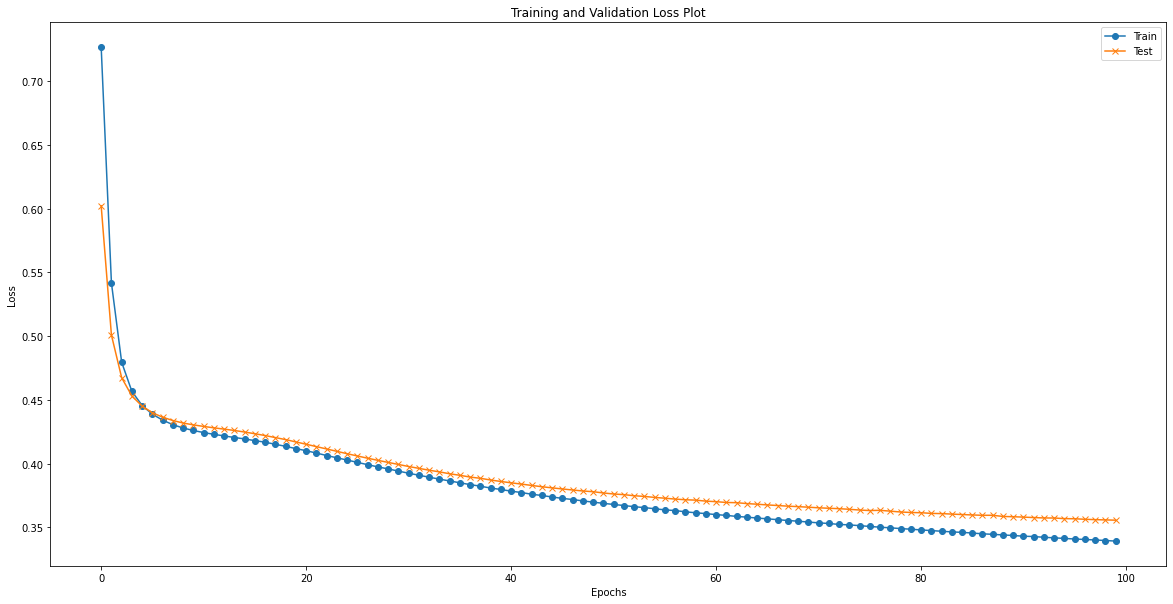

In [26]:
plt.figure(figsize=(20,10))
plt.title('Training and Validation Loss Plot')
pyplot.plot(range(0,100), history.history['loss'], '-o', label='Train')
pyplot.plot(range(0,100), history.history['val_loss'], '-x', label='Test')
pyplot.legend()
pyplot.xlabel('Epochs')
pyplot.ylabel('Loss')
pyplot.show()

We are now using `Early Stopping` method to stop overfitting.

In [27]:
model = Sequential()
model.add(Dense(11,activation='sigmoid',input_dim=11)) #Input layer
model.add(Dense(1,activation='sigmoid'))               #Output layer

In [28]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.00001,
    patience=5,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False
)

In [29]:
history = model.fit(X_train,y_train,epochs=100,validation_split=0.2, callbacks=callback)

Epoch 1/100
200/200 [==============================] - 1s 4ms/step - loss: 0.5322 - accuracy: 0.7800 - val_loss: 0.5006 - val_accuracy: 0.7969
Epoch 2/100
200/200 [==============================] - 0s 2ms/step - loss: 0.5030 - accuracy: 0.7958 - val_loss: 0.4965 - val_accuracy: 0.7969
Epoch 3/100
200/200 [==============================] - 0s 2ms/step - loss: 0.5030 - accuracy: 0.7958 - val_loss: 0.4957 - val_accuracy: 0.7969
Epoch 4/100
200/200 [==============================] - 0s 2ms/step - loss: 0.5007 - accuracy: 0.7958 - val_loss: 0.4977 - val_accuracy: 0.7969
Epoch 5/100
200/200 [==============================] - 0s 2ms/step - loss: 0.5002 - accuracy: 0.7958 - val_loss: 0.4953 - val_accuracy: 0.7969
Epoch 6/100
200/200 [==============================] - 0s 2ms/step - loss: 0.5000 - accuracy: 0.7958 - val_loss: 0.5013 - val_accuracy: 0.7969
Epoch 7/100
200/200 [==============================] - 0s 2ms/step - loss: 0.5015 - accuracy: 0.7958 - val_loss: 0.4942 - val_accuracy: 0.7969

**Resources:-**

1. https://www.kaggle.com/code/campusx/notebook8ad570467f/notebook
2. https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35